In [36]:
import torch
import torch.nn as nn
import h5py
import sys
import h5py
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import librosa
from torch.nn.utils.rnn import pad_sequence
from tqdm.notebook import tqdm

sys.path.append('../')  # required to use harmony package

from harmony.models.seq2seq import TransformerEncoder, TransformerDecoder, Seq2SeqTransformer
from harmony.pianoroll import compute_chroma, compute_tonnetz, compute_harmony_similarity

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


Carregando os dados para o Modelo


In [20]:
"""
    Tokenizacao das labels dos dados do FROG, as labels sao vetores de tamanho 6, cada vetor distinto recebera um token
"""

base_path = "/storage/datasets/thiago.poppe/BPS_FH/dataset/"
splits = ['train', 'validation']

all_labels = {'<sos>', '<eos>'}
for nome_split in splits:
    with h5py.File(f"{base_path}{nome_split}.h5", "r") as fp:
        for dt in fp:
            labels = fp[dt]['labels'][:]
            transposed_labels = labels.T
            
            for row in transposed_labels:
                label_str = ' '.join([str(num) for num in row])
                all_labels.add(label_str)
    
token_dict = {string: i for i, string in enumerate(all_labels)}

In [37]:
class PianoRollDataSet(Dataset):
    def __init__(self, split):
        self.filepath = f'/storage/datasets/thiago.poppe/BPS_FH/dataset/{split}.h5'
        with h5py.File(self.filepath, 'r') as fp:
            self.dataset_size = len(fp.keys())
    
    def __len__(self):
        return self.dataset_size
        
    def __getitem__(self, idx):
        with h5py.File(self.filepath, 'r') as fp:
            data = fp[f'data_{idx}']
            pianoroll = data['pianoroll'][:][0]
            labels = data['labels'][:]
            mask = data['mask'][:][0]
            chroma = compute_chroma(pianoroll)
            tonnetz = compute_tonnetz(chroma)
            similarity = tonnetz @ tonnetz.T
            # similarity = compute_harmony_similarity(tonnetz)


        labels = np.array(list(map(lambda row: token_dict[' '.join([str(num) for num in row])], labels.T)))
        return pianoroll, labels, mask, tonnetz, similarity

In [38]:
def collate_fn(batches):
    pianoroll = [torch.from_numpy(batch[0]).float() for batch in batches]
    pianoroll = torch.stack(pianoroll)
    
    labels = [torch.from_numpy(batch[1]) for batch in batches]
    labels = pad_sequence(labels, batch_first=True)

    mask = [torch.from_numpy(batch[2]) for batch in batches]
    mask = pad_sequence(mask, batch_first=True)

    tonnetz = [torch.from_numpy(batch[3]) for batch in batches]
    tonnetz = torch.stack(tonnetz)

    similarity = [torch.from_numpy(batch[4]) for batch in batches]
    similarity = torch.stack(similarity)
    

    return pianoroll, labels, ~mask.bool(), tonnetz, similarity


In [39]:
train_dataset = PianoRollDataSet('train')
valid_dataset = PianoRollDataSet('validation')

In [40]:
pianoroll, labels, mask, tonnetz, similarity = train_dataset[0]
pianoroll.shape, labels.shape, mask.shape, tonnetz.shape, similarity.shape

((640, 12), (160,), (160,), (640, 6), (640, 640))

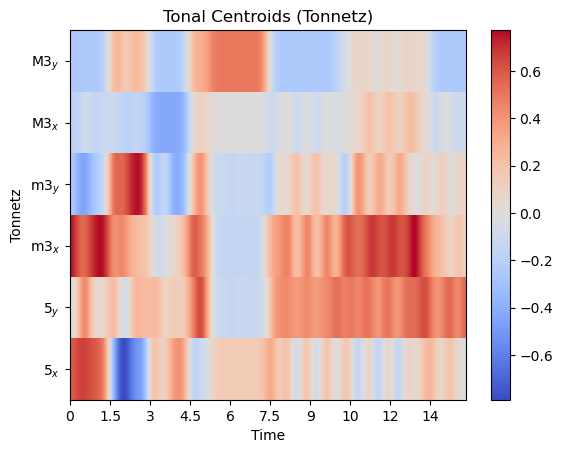

In [41]:
fig, ax = plt.subplots(nrows=1, sharex=True)
img1 = librosa.display.specshow(tonnetz.T, y_axis='tonnetz', x_axis='time', ax=ax)
ax.set(title='Tonal Centroids (Tonnetz)')
ax.label_outer()
fig.colorbar(img1, ax=ax)

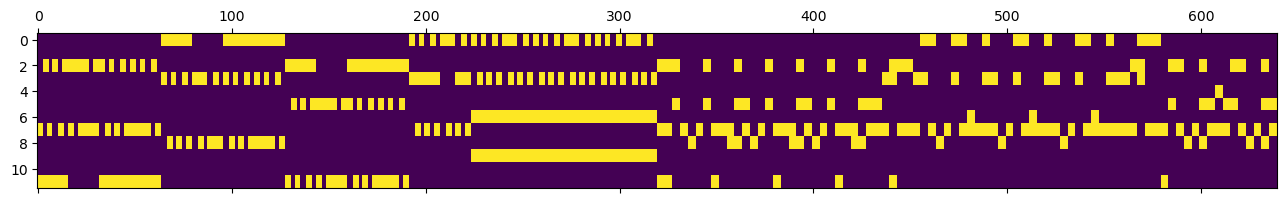

In [42]:
plt.matshow(pianoroll.T, aspect='auto')

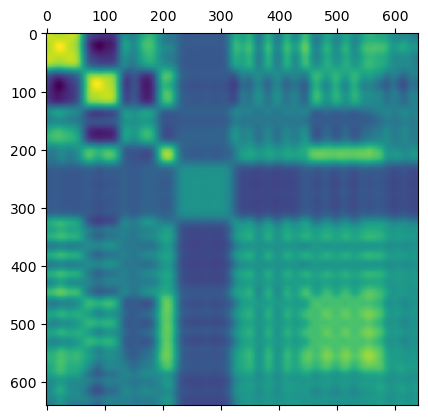

In [43]:
plt.matshow(similarity, aspect='auto')

In [44]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
len(train_dataloader)
validation_dataloader = DataLoader(valid_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
len(train_dataloader)

for pianoroll, labels, mask, tonnetz, similarity in tqdm(train_dataloader):
    continue
for pianoroll, labels, mask, tonnetz, similarity in tqdm(validation_dataloader):
    continue
    
pianoroll.shape, labels.shape, mask.shape, tonnetz.shape, similarity.shape

  0%|          | 0/333 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

(torch.Size([5, 640, 12]),
 torch.Size([5, 160]),
 torch.Size([5, 160]),
 torch.Size([5, 640, 6]),
 torch.Size([5, 640, 640]))

Definindo o Modelo


In [45]:
encoder = TransformerEncoder(in_features=12 , embedding_size=8, num_heads=1, dim_feedforward=16, num_layers=1)
decoder = TransformerDecoder(vocab_size=len(token_dict), embedding_size=8, num_heads=1, dim_feedforward=16, num_layers=1)
model = Seq2SeqTransformer(encoder, decoder).to(device)

print('Number of learnable parameters:', sum(p.numel() for p in model.parameters()))
print(model)

Number of learnable parameters: 49106
Seq2SeqTransformer(
  (encoder): TransformerEncoder(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=8, out_features=8, bias=True)
          )
          (linear1): Linear(in_features=8, out_features=16, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=16, out_features=8, bias=True)
          (norm1): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (embedding): LinearEmbeddingLayer(
      (embedding): Linear(in_features=12, out_features=8, bias=True)
      (pos_encoding): PositionalEncoding(
        (dropout): Dropout(p=0.1, inplace=

Testando a Rede

In [47]:
src = torch.rand(4, 640, 12).to(device)
tgt = torch.randint(low=0, high=len(token_dict), size=(4, 160)).long().to(device)

padding_mask = torch.zeros(4, 160).bool().to(device)
tgt_causal_mask = nn.Transformer.generate_square_subsequent_mask(160).to(device)  
outputs = model(src, tgt, tgt_mask=tgt_causal_mask, padding_mask=padding_mask) # src_mask = pianoroll_tonnetz / pianoroll_similarity
print('Tamanho da sáida:', outputs.shape)

Tamanho da sáida: torch.Size([4, 160, 2794])


Treinando o Modelo

In [49]:
def train(model, train_dataloader, criterion, optimizer):
    train_loss = 0.0
    train_acc = 0.0
    
    model.train()
    for pianoroll, label, padding_mask, tonnetz, similarity in tqdm(train_dataloader): #!!!! ,pianoroll_similarity
        pianoroll = pianoroll.to(device)
        tonnetz = tonnetz.to(device)
        similarity = similarity.to(device)

        batch_size = label.size(0)
        sos_tokens = torch.full((batch_size, 1), fill_value=token_dict['<sos>'])
        eos_tokens = torch.full((batch_size, 1), fill_value=token_dict['<eos>'])

        decoder_input = torch.cat([sos_tokens, label], dim=1).to(device)
        decoder_target = torch.cat([label, eos_tokens], dim=1).to(device)

        falses = torch.full((batch_size, 1), fill_value=False)
        padding_mask = torch.cat([falses, padding_mask], dim=1).to(device)
        tgt_causal_mask = nn.Transformer.generate_square_subsequent_mask(decoder_input.size(1)).to(device)
        
        outputs = model(pianoroll, decoder_input, src_mask=similarity, tgt_mask=tgt_causal_mask, padding_mask=padding_mask) #!!!! src_mask=pianoroll_similarity
        loss = criterion(outputs.transpose(1,2), decoder_target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        predictions = torch.argmax(outputs, dim=-1)
        train_acc += torch.sum(predictions.flatten() == decoder_target.flatten()) / len(predictions.flatten())
    
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    
    return train_loss, train_acc

def validate(model, validation_dataloader, criterion):
    valid_loss = 0.0
    valid_acc = 0.0
    
    with torch.no_grad():
        for pianoroll, label, padding_mask, tonnetz, similarity in tqdm(validation_dataloader):
            pianoroll = pianoroll.to(device)
            tonnetz = tonnetz.to(device)
            similarity = similarity.to(device)
            
            batch_size = label.size(0)
            sos_tokens = torch.full((batch_size, 1), fill_value=token_dict['<sos>'])
            eos_tokens = torch.full((batch_size, 1), fill_value=token_dict['<eos>'])
    
            decoder_input = torch.cat([sos_tokens, label], dim=1).to(device)
            decoder_target = torch.cat([label, eos_tokens], dim=1).to(device)
    
            falses = torch.full((batch_size, 1), fill_value=False)
            padding_mask = torch.cat([falses, padding_mask], dim=1).to(device)
            tgt_causal_mask = nn.Transformer.generate_square_subsequent_mask(decoder_input.size(1)).to(device)
            
            outputs = model(pianoroll, decoder_input, src_mask=similarity, tgt_mask=tgt_causal_mask, padding_mask=padding_mask)
            loss = criterion(outputs.transpose(1,2), decoder_target)
            valid_loss += loss.item()

            predictions = torch.argmax(outputs, dim=-1)
            valid_acc += torch.sum(predictions.flatten() == decoder_target.flatten()) / len(predictions.flatten())
    
        valid_loss /= len(validation_dataloader)
        valid_acc /= len(validation_dataloader)
        
        return valid_loss, valid_acc

In [50]:
import torch.optim as optim

num_epochs = 100
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_accs = []
valid_accs = []

train_losses = []
valid_losses = []
for epoch in range(1, num_epochs+1):
    train_loss, train_acc = train(model, train_dataloader, criterion, optimizer)
    valid_loss, valid_acc = validate(model, validation_dataloader, criterion)

    if epoch % 2 == 0:
        print(f'Epoch {epoch}/{num_epochs}:')
        print(f' - Train loss: {train_loss:.5f}, train accuracy: {train_acc:.5f}')
        print(f' - Valid loss: {valid_loss:.5f}, valid accuracy: {valid_acc:.5f}', end='\n\n')

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        train_accs.append(train_acc)
        valid_accs.append(valid_acc)

  0%|          | 0/333 [00:00<?, ?it/s]

KeyboardInterrupt: 